<a href="https://colab.research.google.com/github/ArthAgrawal/Vision-Transformer-in-SER/blob/main/SER_Models_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Subfolder: Neutral, Number of Files: 96
Subfolder: Calm, Number of Files: 192
Subfolder: Happy, Number of Files: 192
Subfolder: Sad, Number of Files: 192
Subfolder: Angry, Number of Files: 192
Subfolder: Fearful, Number of Files: 192
Subfolder: Disgust, Number of Files: 192
Subfolder: Surprised, Number of Files: 192

Total Number of Files: 1440


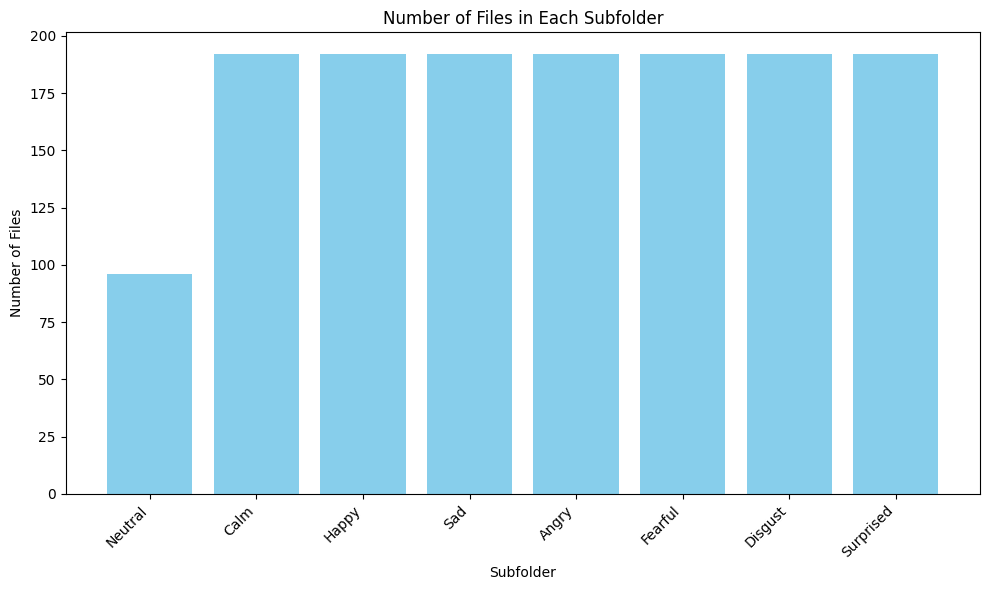

In [ ]:
import os
import matplotlib.pyplot as plt

# Path to the parent folder containing subfolders
parent_folder = '/content/drive/MyDrive/RAVDESS'

# Get all subfolders in the parent folder
subfolders = [f.path for f in os.scandir(parent_folder) if f.is_dir()]

# Count the number of files in each subfolder
file_counts = {}
total_files = 0
for subfolder in subfolders:
    count = len([f for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))])
    file_counts[os.path.basename(subfolder)] = count
    total_files += count

# Print the number of files in each subfolder and total files
for subfolder, count in file_counts.items():
    print(f"Subfolder: {subfolder}, Number of Files: {count}")

print(f"\nTotal Number of Files: {total_files}")

# Plot the number of files in each subfolder
plt.figure(figsize=(10, 6))
plt.bar(file_counts.keys(), file_counts.values(), color='skyblue')
plt.xlabel('Subfolder')
plt.ylabel('Number of Files')
plt.title('Number of Files in Each Subfolder')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
!pip uninstall librosa numba -y
!pip install librosa numba

In [ ]:
!pip install audiomentations

**Pre-Processing the audio files**

In [ ]:
import librosa
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm  # For progress tracking
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift

# Emotion mapping (emotion numbers to names)
emotion_mapping = {
    "01": "Neutral",
    "02": "Calm",
    "03": "Happy",
    "04": "Sad",
    "05": "Angry",
    "06": "Fearful",
    "07": "Disgust",
    "08": "Surprised"
}

# Update the augmentation pipeline with additional transformations
augmenter = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),  # Add noise
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),  # Time stretch audio
    PitchShift(min_semitones=-6, max_semitones=6, p=0.5),  # Shift pitch
])

# Function to apply augmentations to the audio before converting to Mel Spectrogram
def audio_to_mel_spectrogram_with_augmentation(audio_path, augmenter, sr=22050, n_mels=128, fmax=8000, max_len=128):
    y, sr = librosa.load(audio_path, sr=sr)

    # Apply augmentations
    augmented_y = augmenter(samples=y, sample_rate=sr)

    mel_spectrogram = librosa.feature.melspectrogram(y=augmented_y, sr=sr, n_mels=n_mels, fmax=fmax)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Padding or truncating to ensure consistent length
    if mel_spectrogram_db.shape[1] > max_len:
        mel_spectrogram_db = mel_spectrogram_db[:, :max_len]
    elif mel_spectrogram_db.shape[1] < max_len:
        pad_width = max_len - mel_spectrogram_db.shape[1]
        mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, pad_width)), mode='constant')

    return mel_spectrogram_db

# Collect spectrograms and labels with augmentation
X = []
y = []

base_path = "/content/drive/MyDrive/RAVDESS"  # Update with your path

# Wrap the for loop with tqdm for progress tracking
for emotion_folder in tqdm(os.listdir(base_path), desc="Processing files", unit="folder"):
    emotion_path = os.path.join(base_path, emotion_folder)

    if os.path.isdir(emotion_path):
        for filename in os.listdir(emotion_path):
            # Check for supported audio file formats
            if filename.endswith((".wav", ".mp3", ".flac")):
                emotion_number = filename.split('-')[2]
                emotion = emotion_mapping.get(emotion_number, None)
                if emotion:
                    audio_path = os.path.join(emotion_path, filename)
                    # Apply augmentation and convert to Mel Spectrogram
                    mel_spectrogram = audio_to_mel_spectrogram_with_augmentation(audio_path, augmenter)
                    X.append(mel_spectrogram)
                    y.append(emotion)

                    # Apply the augmentations 4 more times to achieve a 5x expansion
                    for _ in range(4):  # Generate 4 more augmented versions per sample, making it 5 times the size
                        mel_spectrogram_aug = audio_to_mel_spectrogram_with_augmentation(audio_path, augmenter)
                        X.append(mel_spectrogram_aug)
                        y.append(emotion)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Expanded Dataset size: {X.shape}, Labels size: {y.shape}")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded, num_classes=8)

# Add a channel dimension to the data (grayscale images, so 1 channel)
X = np.expand_dims(X, axis=-1)  # Shape becomes (N, 128, 128, 1)

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Further split the train set into train and validation (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the input shape based on the spectrogram size and number of channels (1 channel for grayscale)
input_shape = (X_train.shape[1], X_train.shape[2], 1)  # (128, 128, 1) for grayscale images
num_classes = 8  # Number of emotions

# Print the shapes to verify
print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}, Test data shape: {X_test.shape}")


Processing files: 100%|██████████| 8/8 [12:58<00:00, 97.28s/folder]


Expanded Dataset size: (7200, 128, 128), Labels size: (7200,)
Training data shape: (4608, 128, 128, 1), Validation data shape: (1152, 128, 128, 1), Test data shape: (1440, 128, 128, 1)


**Simple CNN**

In [ ]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input

def create_stronger_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape, name="input_layer")

    # Convolutional Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Convolutional Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Convolutional Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Convolutional Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Global Average Pooling to reduce the feature map size
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create Model
    model = models.Model(inputs=inputs, outputs=outputs, name="Stronger_CNN")
    return model

# Create the model
model = create_stronger_cnn(input_shape, num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "Stronger_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 32, 32, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 512)                 │         262,6

 Total params: 1,825,167 (6.96 MB)

 Trainable params: 1,823,247 (6.96 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
import matplotlib.pyplot as plt

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 162ms/step - accuracy: 0.1571 - loss: 13.2322 - val_accuracy: 0.1181 - val_loss: 12.3410
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.2206 - loss: 11.9715 - val_accuracy: 0.1623 - val_loss: 11.4574
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.2690 - loss: 10.9973 - val_accuracy: 0.1502 - val_loss: 10.6317
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.3027 - loss: 10.1166 - val_accuracy: 0.1762 - val_loss: 9.8630
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.3374 - loss: 9.3365 - val_accuracy: 0.2335 - val_loss: 9.1085
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.3355 - loss: 8.6531 - val_accuracy: 0.2882 - val_loss: 8.4023
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.3654 - loss: 8.0134 - val_accuracy: 0.2960 - val_loss: 7.8598
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.3946 - loss: 7.4280 - val_accuracy: 0

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


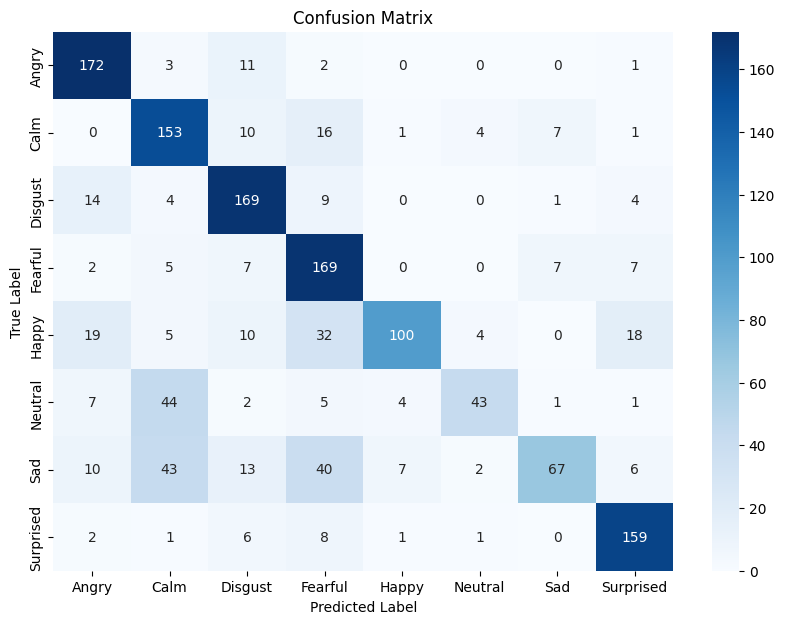

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


**Testing actual predictions**

In [ ]:
# Adjust emotion mapping to use class labels as keys
emotion_mapping = {
    'Neutral': 'Neutral',
    'Calm': 'Calm',
    'Happy': 'Happy',
    'Sad': 'Sad',
    'Angry': 'Angry',
    'Fearful': 'Fearful',
    'Disgust': 'Disgust',
    'Surprised': 'Surprised'
}

def predict_emotion(audio_path, model, label_encoder, emotion_mapping, sr=22050, n_mels=128, fmax=8000, max_len=128):
    # Load and process audio (same as before)
    y, sr = librosa.load(audio_path, sr=sr)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Padding or truncating to ensure consistent length
    if mel_spectrogram_db.shape[1] > max_len:
        mel_spectrogram_db = mel_spectrogram_db[:, :max_len]
    elif mel_spectrogram_db.shape[1] < max_len:
        pad_width = max_len - mel_spectrogram_db.shape[1]
        mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, pad_width)), mode='constant')

    # Expand dimensions to match input shape
    mel_spectrogram_db = np.expand_dims(mel_spectrogram_db, axis=-1)  # Add channel dimension
    mel_spectrogram_db = np.expand_dims(mel_spectrogram_db, axis=0)   # Add batch dimension

    # Make prediction
    predictions = model.predict(mel_spectrogram_db)
    predicted_class_index = np.argmax(predictions, axis=1)  # Get index of the highest probability

    # Print the predicted index and label encoder classes
    print("Predicted class index:", predicted_class_index)
    print("Classes in label encoder:", label_encoder.classes_)

    # Decode predicted class to emotion name
    predicted_class = label_encoder.inverse_transform(predicted_class_index)
    print("Predicted class after inverse transform:", predicted_class)

    # Map the predicted class to emotion based on emotion_mapping
    predicted_emotion = emotion_mapping.get(predicted_class[0], "Unknown")

    # Convert probabilities to percentages
    prediction_percentages = predictions[0] * 100
    prediction_percentages = [f"{prob:.2f}%" for prob in prediction_percentages]

    return predicted_emotion, prediction_percentages

# Test the prediction
audio_path = "/content/drive/MyDrive/RAVDESS/Neutral/03-01-01-01-01-01-06.wav"   # Replace with an actual file path
predicted_emotion, prediction_percentages = predict_emotion(audio_path, model, label_encoder, emotion_mapping)

# Print the result
print(f"Predicted Emotion: {predicted_emotion}")
print("Class Probabilities (in percentages):", prediction_percentages)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted class index: [5]
Classes in label encoder: ['Angry' 'Calm' 'Disgust' 'Fearful' 'Happy' 'Neutral' 'Sad' 'Surprised']
Predicted class after inverse transform: ['Neutral']
Predicted Emotion: Neutral
Class Probabilities (in percentages): ['6.52%', '12.39%', '1.31%', '3.45%', '17.67%', '51.88%', '1.70%', '5.08%']


In [ ]:
# Save the model to a file
model.save('/content/drive/MyDrive/SER_Models/SER1.h5')  # Specify the path where you want to save the model

In [ ]:
from tensorflow.keras.models import load_model
# Load the model from the saved file
model = load_model('/content/drive/MyDrive/SER_Models/SER1.h5')  # Use the correct path to your saved model

# Use the same emotion mapping
emotion_mapping = {
    'Neutral': 'Neutral',
    'Calm': 'Calm',
    'Happy': 'Happy',
    'Sad': 'Sad',
    'Angry': 'Angry',
    'Fearful': 'Fearful',
    'Disgust': 'Disgust',
    'Surprised': 'Surprised'
}

# Define the prediction function as before
def predict_emotion(audio_path, model, label_encoder, emotion_mapping, sr=22050, n_mels=128, fmax=8000, max_len=128):
    # Load and process audio (same as before)
    y, sr = librosa.load(audio_path, sr=sr)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Padding or truncating to ensure consistent length
    if mel_spectrogram_db.shape[1] > max_len:
        mel_spectrogram_db = mel_spectrogram_db[:, :max_len]
    elif mel_spectrogram_db.shape[1] < max_len:
        pad_width = max_len - mel_spectrogram_db.shape[1]
        mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, pad_width)), mode='constant')

    # Expand dimensions to match input shape
    mel_spectrogram_db = np.expand_dims(mel_spectrogram_db, axis=-1)  # Add channel dimension
    mel_spectrogram_db = np.expand_dims(mel_spectrogram_db, axis=0)   # Add batch dimension

    # Make prediction
    predictions = model.predict(mel_spectrogram_db)
    predicted_class_index = np.argmax(predictions, axis=1)  # Get index of the highest probability

    # Decode predicted class to emotion name
    predicted_class = label_encoder.inverse_transform(predicted_class_index)

    # Map the predicted class to emotion based on emotion_mapping
    predicted_emotion = emotion_mapping.get(predicted_class[0], "Unknown")

    # Convert probabilities to percentages
    prediction_percentages = predictions[0] * 100
    prediction_percentages = [f"{prob:.2f}%" for prob in prediction_percentages]

    return predicted_emotion, prediction_percentages

# Test the prediction with the loaded model
audio_path = "/content/drive/MyDrive/RAVDESS/Sad/03-01-04-01-01-02-18.wav"  # Replace with the correct file path
predicted_emotion, prediction_percentages = predict_emotion(audio_path, model, label_encoder, emotion_mapping)

# Print the result
print(f"Predicted Emotion: {predicted_emotion}")
print("Class Probabilities (in percentages):", prediction_percentages)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Emotion: Happy
Class Probabilities (in percentages): ['7.26%', '6.85%', '10.27%', '15.73%', '44.17%', '2.02%', '12.80%', '0.90%']


**Larger CNN**

Model: "Stronger_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_46 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_60 (Dropout)                 │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_61 (Dropout)                 │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 8, 8, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 8, 8, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │              

 Total params: 6,806,280 (25.96 MB)

 Trainable params: 6,802,312 (25.95 MB)

 Non-trainable params: 3,968 (15.50 KB)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 198ms/step - accuracy: 0.1501 - loss: 21.9876 - val_accuracy: 0.1337 - val_loss: 20.7459
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.2218 - loss: 20.1592 - val_accuracy: 0.1363 - val_loss: 19.9963
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.2605 - loss: 18.7673 - val_accuracy: 0.1450 - val_loss: 19.0316
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.2861 - loss: 17.3915 - val_accuracy: 0.1519 - val_loss: 18.3061
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.3076 - loss: 16.1047 - val_accuracy: 0.1545 - val_loss: 17.5388
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.3297 - loss: 14.8786 - val_accuracy: 0.1510 - val_loss: 16.1937
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.3651 - loss: 13.7343 - val_accuracy: 0.1866 - val_loss: 15.1509
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.3898 - loss: 12.6865 - 

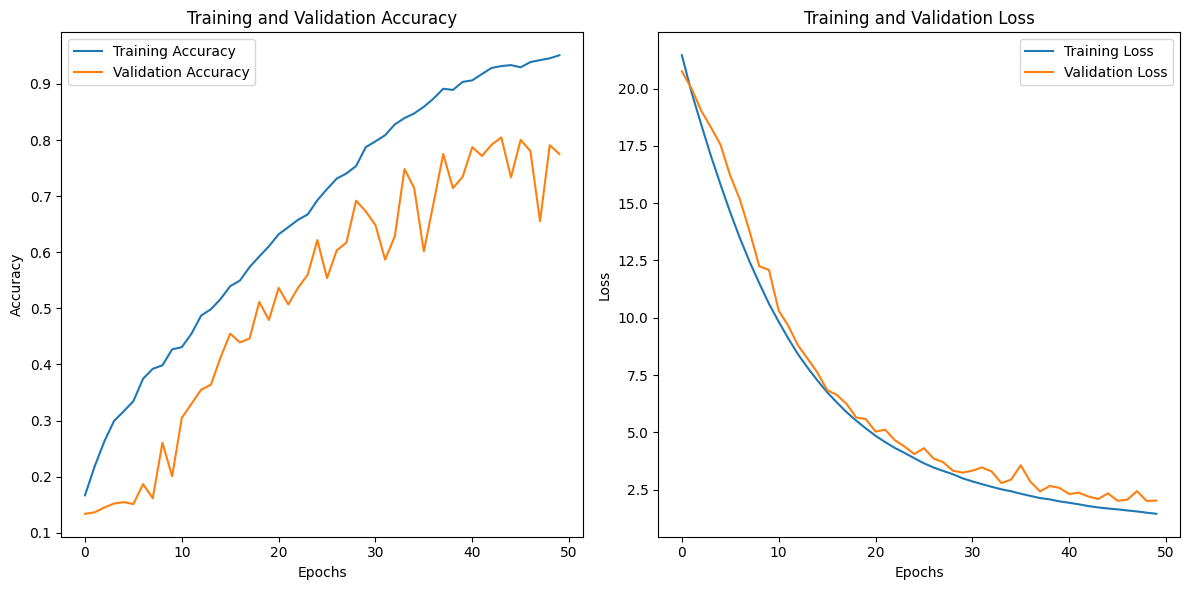

In [ ]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input

def create_stronger_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape, name="input_layer")

    # Convolutional Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Convolutional Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Convolutional Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Convolutional Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Convolutional Block 5
    x = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Global Average Pooling to reduce the feature map size
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)

    # Output Layer
    outputs = Dense(8, activation='softmax')(x)

    # Create Model
    model2 = models.Model(inputs=inputs, outputs=outputs, name="Stronger_CNN")
    return model2

# Adjust the input shape here for grayscale images (128x128, 1 channel)
input_shape = (128, 128, 1)  # Grayscale (1 channel)

# Create the model
model2 = create_stronger_cnn(input_shape, num_classes)

# Compile the model
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model2.summary()

# Train the model
history = model2.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the model
test_loss, test_acc = model2.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


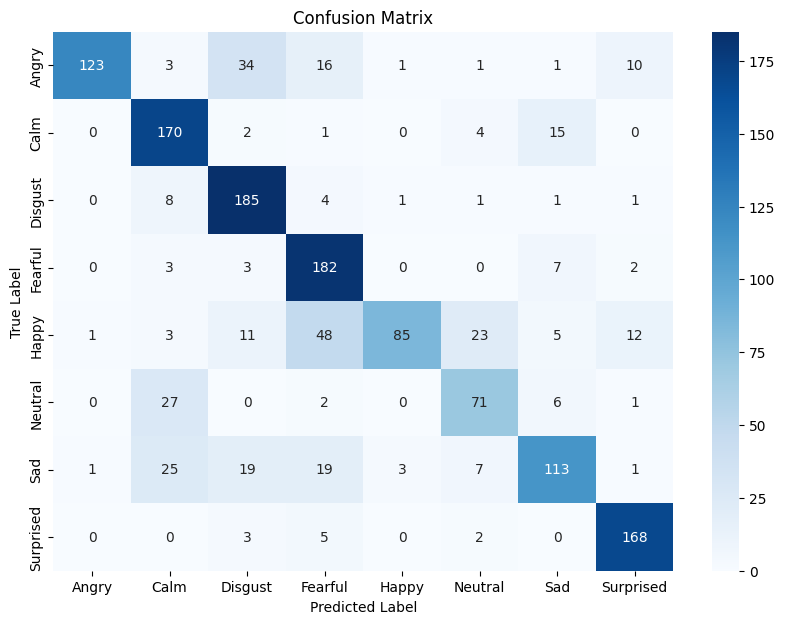

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model2.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


**ResNet50**

In [ ]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, Lambda
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import tensorflow as tf

def create_stronger_cnn_with_resnet(input_shape, num_classes):
    # Load pre-trained ResNet50 model without the top (fully connected) layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(input_shape[0], input_shape[1], 3))  # 3 channels

    # Freeze the layers of the pre-trained model (feature extractor)
    base_model.trainable = False

    # Input layer (convert grayscale to RGB by repeating channels)
    inputs = Input(shape=input_shape, name="input_layer")

    # Use a Lambda layer to repeat the grayscale channel across 3 channels
    x = Lambda(lambda image: tf.repeat(image, 3, axis=-1))(inputs)  # Repeat grayscale across 3 channels

    # Use the pre-trained base model as a feature extractor
    x = base_model(x)

    # Add custom layers on top of the base model
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model3 = Model(inputs=inputs, outputs=outputs, name="Stronger_CNN_with_ResNet")

    return model3

# Adjust the input shape here for grayscale images (128x128, 1 channel)
input_shape = (128, 128, 1)  # Grayscale (1 channel)

# Number of classes (adjust this based on your dataset)
num_classes = 8

# Create the model with ResNet50 transfer learning
model3 = create_stronger_cnn_with_resnet(input_shape, num_classes)

# Compile the model
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model3.summary()


Model: "Stronger_CNN_with_ResNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_12          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,640,904 (94.00 MB)

 Trainable params: 1,053,192 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.1671 - loss: 9.9976 - val_accuracy: 0.3785 - val_loss: 8.0043
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.3146 - loss: 7.7202 - val_accuracy: 0.4036 - val_loss: 6.5137
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.3499 - loss: 6.3021 - val_accuracy: 0.4280 - val_loss: 5.4456
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.3880 - loss: 5.2869 - val_accuracy: 0.4497 - val_loss: 4.6713
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.4153 - loss: 4.5363 - val_accuracy: 0.4540 - val_loss: 4.0958
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.4302 - loss: 3.9836 - val_accuracy: 0.4783 - val_loss: 3.6608
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.4612 - loss: 3.5681 - val_accuracy: 0.4931 - val_loss: 3.3346
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.4833 - loss: 3.2459 - val_accuracy: 0.4931 - 

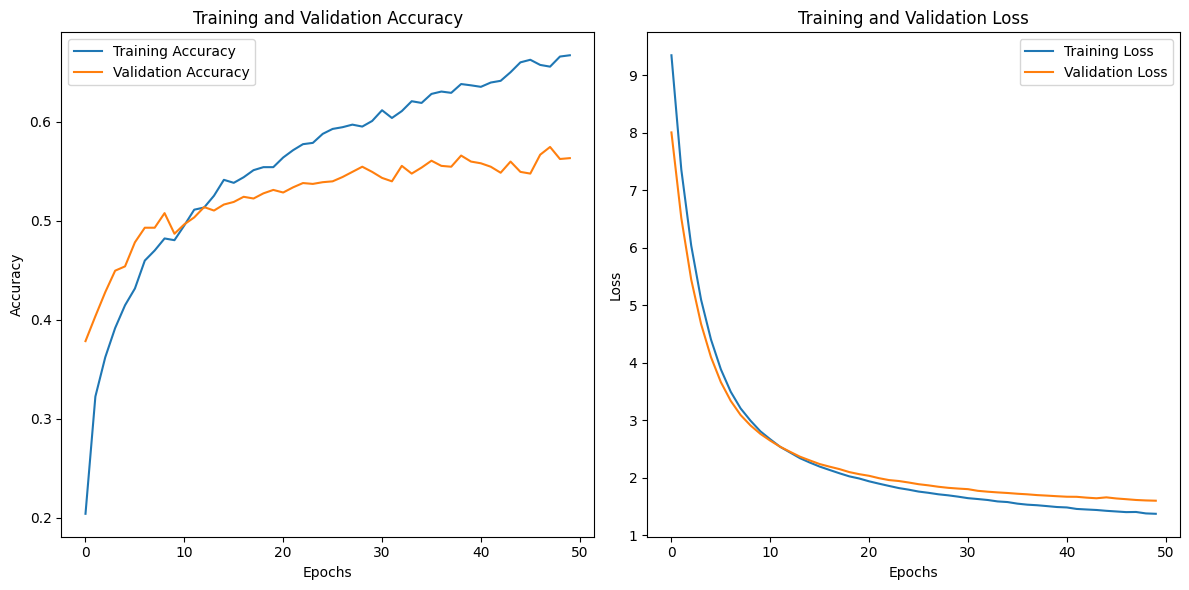

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback to stop training when the validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss (can also monitor 'val_accuracy')
    patience=8,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore the best weights when training stops early
    verbose=1
)

# Train the model with EarlyStopping callback
history = model3.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[early_stopping]  # Add EarlyStopping callback
)

# Evaluate the model
test_loss, test_acc = model3.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


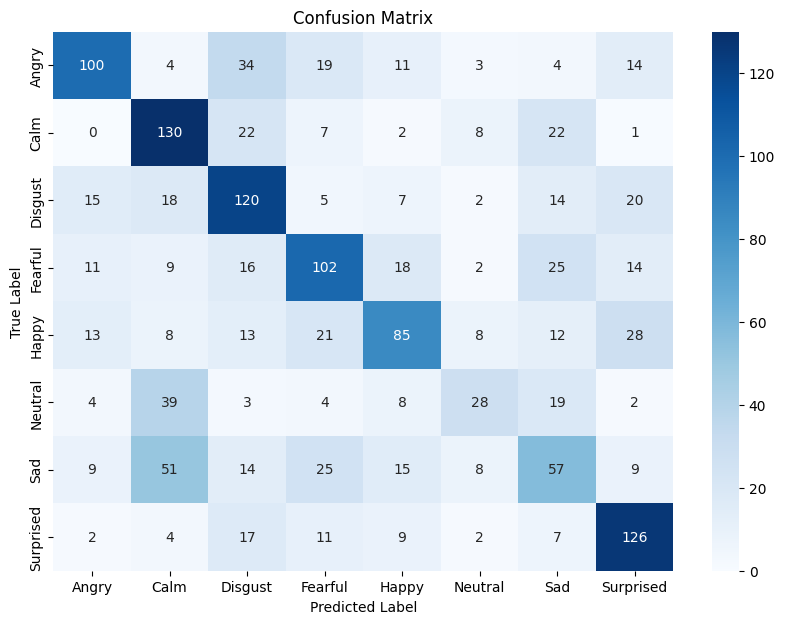

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model3.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


**CNN+LSTM**

Model: "Stronger_CNN_with_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_49               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_65 (Dropout)                 │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_51               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_51 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_52               │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 8, 8, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_53               │ (None, 8, 8, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │              

 Total params: 9,691,912 (36.97 MB)

 Trainable params: 9,687,944 (36.96 MB)

 Non-trainable params: 3,968 (15.50 KB)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 222ms/step - accuracy: 0.1694 - loss: 18.6991 - val_accuracy: 0.1337 - val_loss: 15.1328
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 217ms/step - accuracy: 0.2638 - loss: 13.9354 - val_accuracy: 0.1450 - val_loss: 11.6860
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 218ms/step - accuracy: 0.3112 - loss: 10.6865 - val_accuracy: 0.1476 - val_loss: 9.4126
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 217ms/step - accuracy: 0.3535 - loss: 8.5292 - val_accuracy: 0.2005 - val_loss: 7.9680
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 215ms/step - accuracy: 0.3856 - loss: 7.0057 - val_accuracy: 0.1962 - val_loss: 7.0148
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 215ms/step - accuracy: 0.4314 - loss: 5.8983 - val_accuracy: 0.2491 - val_loss: 6.1528
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 215ms/step - accuracy: 0.4675 - loss: 5.0693 - val_accuracy: 0.1927 - val_loss: 5.9716
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 216ms/step - accuracy: 0.5088 - loss: 4.4562 - val

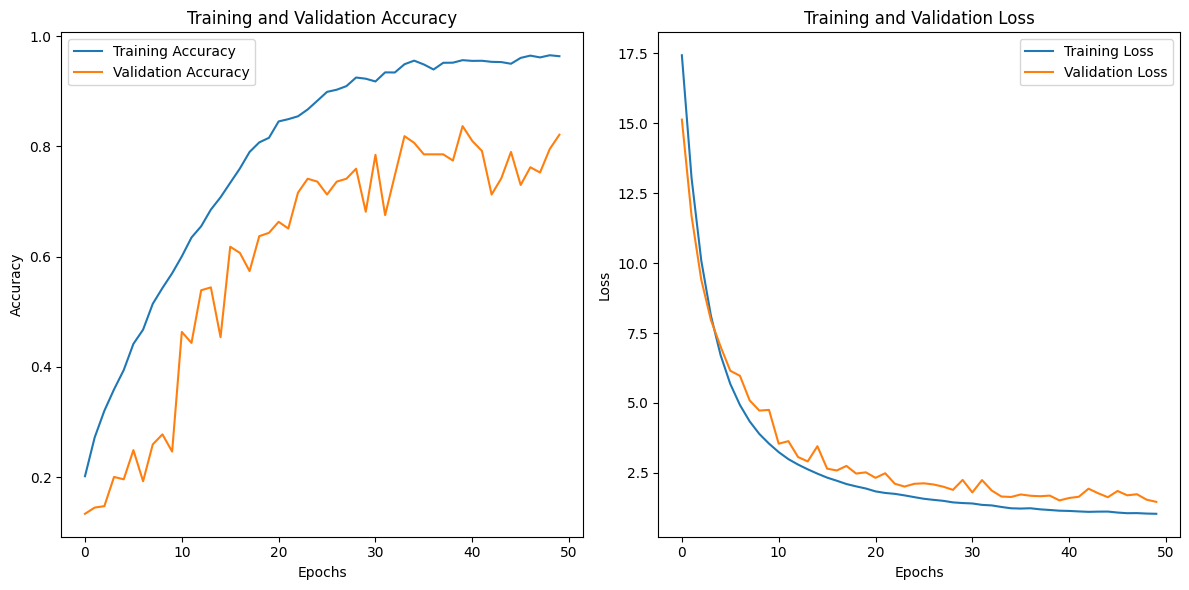

In [ ]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, Flatten, LSTM

def create_stronger_cnn_with_lstm(input_shape, num_classes):
    inputs = Input(shape=input_shape, name="input_layer")

    # Convolutional Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Convolutional Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Convolutional Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Convolutional Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Convolutional Block 5
    x = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Global Average Pooling to reduce the feature map size
    x = GlobalAveragePooling2D()(x)

    # Reshape output for LSTM layer (adding a time dimension)
    x = Flatten()(x)
    x = layers.Reshape((-1, 1024))(x)  # Reshaping to (batch_size, time_steps, features) for LSTM

    # Add an LSTM layer to process the sequences
    x = LSTM(512, return_sequences=False)(x)

    # Fully Connected Layer after LSTM
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create Model
    model4 = models.Model(inputs=inputs, outputs=outputs, name="Stronger_CNN_with_LSTM")
    return model4

# Adjust the input shape here for grayscale images (128x128, 1 channel)
input_shape = (128, 128, 1)  # Grayscale (1 channel)
num_classes = 8  # Set the number of output classes

# Create the model
model4 = create_stronger_cnn_with_lstm(input_shape, num_classes)

# Compile the model
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model4.summary()

# Train the model
history = model4.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the model
test_loss, test_acc = model4.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


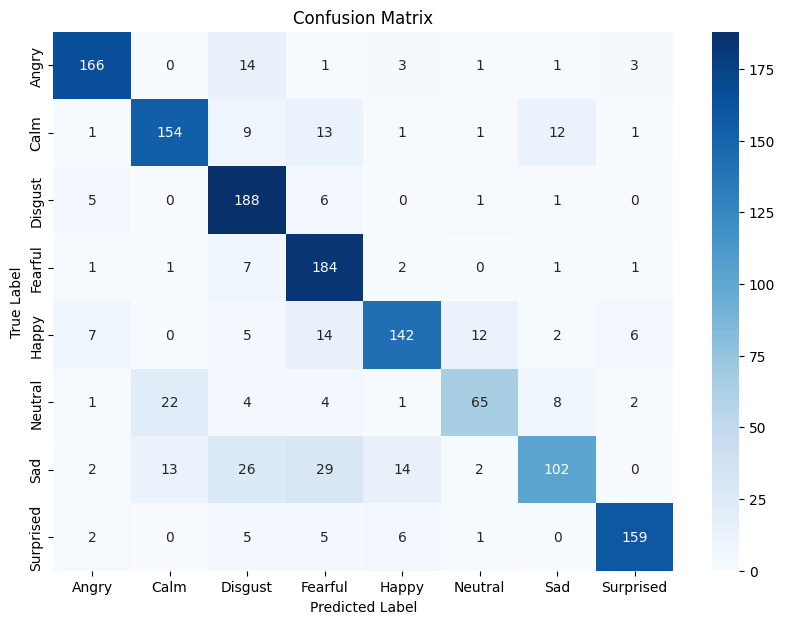

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model4.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# Save the model to a file
model.save('/content/drive/MyDrive/SER_Models/SER2.h5')  # Specify the path where you want to save the model

**CNN+Transformer**

Model: "Stronger_CNN_with_Transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_59    │ (None, 128, 128, 64)   │            256 │ conv2d_59[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_59          │ (None, 64, 64, 64)     │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_78 (Dropout)      │ (None, 64, 64, 64)     │              0 │ max_pooling2d_59[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ dropout_78[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_60    │ (None, 64, 64, 128)    │            512 │ conv2d_60[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_60          │ (None, 32, 32, 128)    │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_79 (Dropout)      │ (None, 32, 32, 128)    │              0 │ max_pooling2d_60[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ dropout_79[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_61    │ (None, 32, 32, 256)    │          1,024 │ conv2d_61[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_61          │ (None, 16, 16, 256)    │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_80 (Dropout)      │ (None, 16, 16, 256)    │              0 │ max_pooling2d_61[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ dropout_80[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_62    │ (None, 16, 16, 512)    │          2,048 │ conv2d_62[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_62          │ (None, 8, 8, 512)      │              0 │ batch_normalization_6… │
│ (MaxPooling2D)       

 Total params: 8,908,040 (33.98 MB)

 Trainable params: 8,904,072 (33.97 MB)

 Non-trainable params: 3,968 (15.50 KB)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (64, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - accuracy: 0.1474 - loss: 21.5113 - val_accuracy: 0.1354 - val_loss: 19.7913
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.1697 - loss: 18.1942 - val_accuracy: 0.1337 - val_loss: 16.7956
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.2084 - loss: 14.8978 - val_accuracy: 0.1354 - val_loss: 14.3310
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.2492 - loss: 12.1126 - val_accuracy: 0.1337 - val_loss: 12.7485
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.2971 - loss: 9.9448 - val_accuracy: 0.1450 - val_loss: 10.3938
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.3528 - loss: 8.3402 - val_accuracy: 0.2491 - val_loss: 7.7709
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.3701 - loss: 7.1572 - val_accuracy: 0.2674 - val_loss: 6.8891
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.4194 - loss: 6.2047 - val_accuracy: 0.2

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


45/45 - 2s - 50ms/step - accuracy: 0.7951 - loss: 1.9167
Test accuracy: 0.7951388955116272


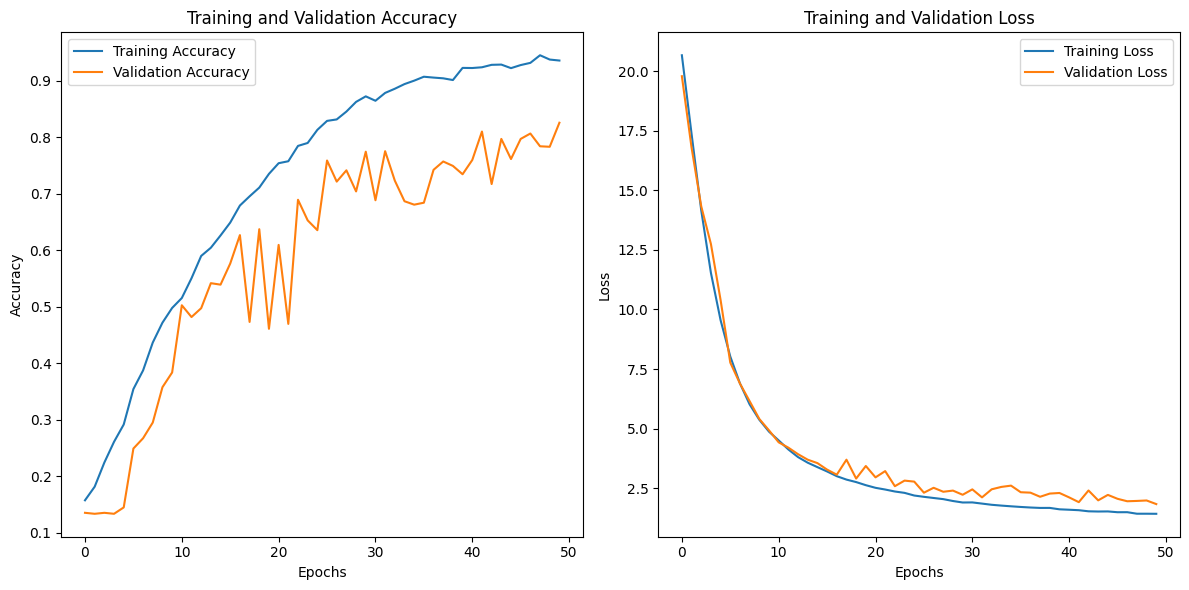

In [ ]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, MultiHeadAttention, LayerNormalization

def create_stronger_cnn_with_transformer(input_shape, num_classes):
    inputs = Input(shape=input_shape, name="input_layer")

    # Convolutional Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Convolutional Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Convolutional Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Convolutional Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Convolutional Block 5
    x = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Global Average Pooling to reduce the feature map size
    x = GlobalAveragePooling2D()(x)

    # Reshape output for Transformer layer (adding a time dimension)
    x = layers.Reshape((-1, 1024))(x)  # Reshaping to (batch_size, time_steps, features)

    # Transformer Layer (Multi-Head Attention)
    transformer = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
    transformer = LayerNormalization()(transformer)

    # Apply Global Average Pooling along the time dimension
    transformer = layers.GlobalAveragePooling1D()(transformer)

    # Fully Connected Layer after Transformer
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(transformer)
    x = Dropout(0.5)(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create Model
    model5 = models.Model(inputs=inputs, outputs=outputs, name="Stronger_CNN_with_Transformer")
    return model5

# Adjust the input shape here for grayscale images (128x128, 1 channel)
input_shape = (128, 128, 1)  # Grayscale (1 channel)
num_classes = 8  # Set the number of output classes

# Create the model
model5 = create_stronger_cnn_with_transformer(input_shape, num_classes)

# Compile the model
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model5.summary()

# Train the model
history = model5.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the model
test_loss, test_acc = model5.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


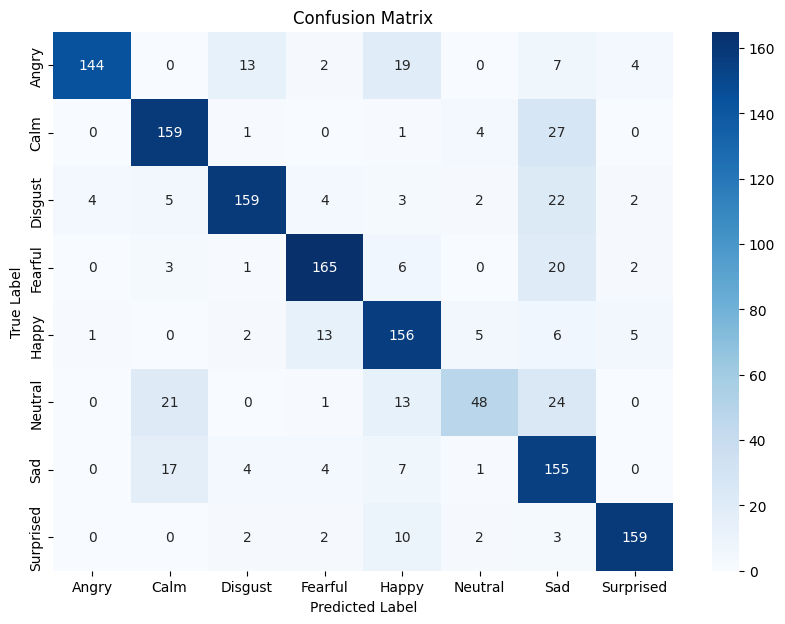

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model5.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


**CNN+Vision Transformer**

Model: "ViT_CNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_88 (Conv2D)        │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_82    │ (None, 128, 128, 64)   │            256 │ conv2d_88[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_82          │ (None, 64, 64, 64)     │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_128 (Dropout)     │ (None, 64, 64, 64)     │              0 │ max_pooling2d_82[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_89 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ dropout_128[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_83    │ (None, 64, 64, 128)    │            512 │ conv2d_89[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_83          │ (None, 32, 32, 128)    │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_129 (Dropout)     │ (None, 32, 32, 128)    │              0 │ max_pooling2d_83[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_90 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ dropout_129[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_84    │ (None, 32, 32, 256)    │          1,024 │ conv2d_90[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_84          │ (None, 16, 16, 256)    │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_130 (Dropout)     │ (None, 16, 16, 256)    │              0 │ max_pooling2d_84[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_91 (Conv2D)        │ (None, 1, 1, 64)       │      4,194,368 │ dropout_130[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_9 (Reshape)       │ (None, 1, 64)          │              0 │ conv2d_91[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (1, 16, 64)            │              0 │ reshape_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1

 Total params: 5,267,272 (20.09 MB)

 Trainable params: 5,266,376 (20.09 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - accuracy: 0.1847 - loss: 5.9328 - val_accuracy: 0.1771 - val_loss: 4.5887
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.2728 - loss: 5.0877 - val_accuracy: 0.2257 - val_loss: 4.5334
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.3054 - loss: 4.7419 - val_accuracy: 0.1719 - val_loss: 4.6012
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.3425 - loss: 4.4732 - val_accuracy: 0.2812 - val_loss: 4.2910
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.3643 - loss: 4.2396 - val_accuracy: 0.2222 - val_loss: 4.6259
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.4162 - loss: 4.0150 - val_accuracy: 0.2943 - val_loss: 4.2523
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.4103 - loss: 3.9109 - val_accuracy: 0.3993 - val_loss: 3.8395
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.4462 - loss: 3.7578 - val_accuracy: 0.4036 -

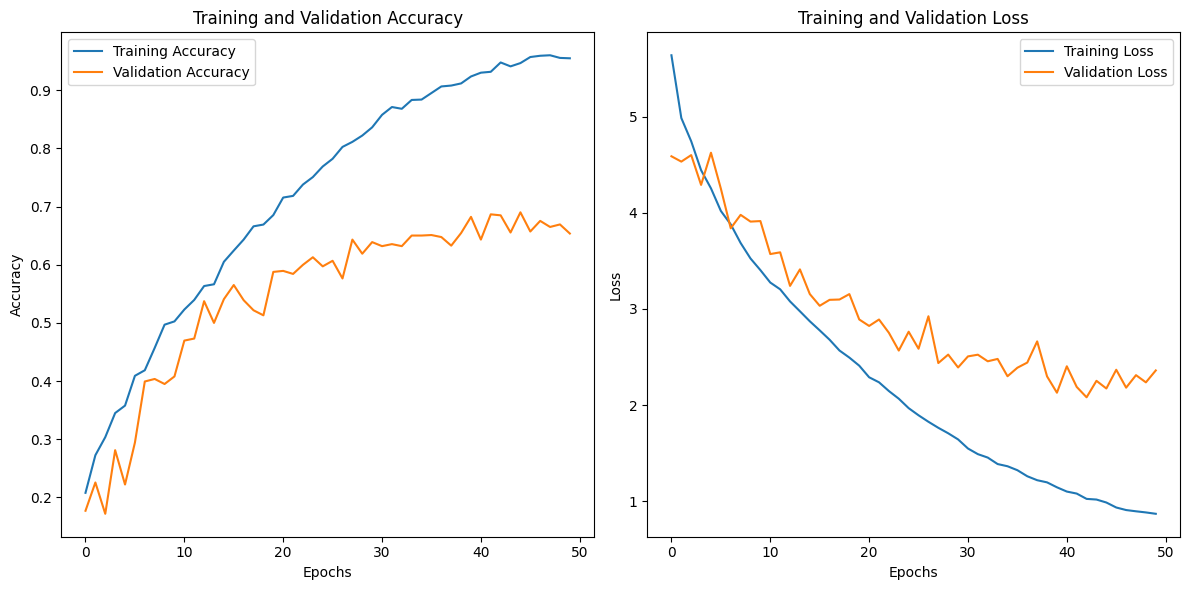

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Input, LayerNormalization

# Function to create Positional Encodings
def get_positional_encoding(num_patches, embedding_dim):
    position = tf.range(num_patches, dtype=tf.float32)  # Shape (num_patches, 1)
    position = position[:, tf.newaxis]

    div_term = tf.exp(tf.range(0, embedding_dim, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / embedding_dim))  # Correct range

    # Calculate the positional encoding without in-place modification
    sinusoid = tf.sin(position * div_term)
    cosinusoid = tf.cos(position * div_term)

    # Stack the sinusoidal components to form the positional encoding
    positional_encoding = tf.concat([sinusoid, cosinusoid], axis=-1)

    return positional_encoding



# Vision Transformer Model Block
def create_vit_model(input_shape, num_classes, patch_size=16, num_patches=16, embedding_dim=64, num_heads=8, num_layers=4):
    inputs = Input(shape=input_shape, name="input_layer")

    # Step 1: Convolutional Blocks for Feature Extraction
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Step 2: Patch Creation
    patch_size = 16
    patches = layers.Conv2D(embedding_dim, patch_size, strides=patch_size)(x)  # Patching image

    # Reshape patches into a sequence (batch_size, num_patches, embedding_dim)
    patches = layers.Reshape((-1, embedding_dim))(patches)

    # Step 3: Positional Embeddings
    # Use the predefined positional encoding
    positional_encoding = get_positional_encoding(num_patches, embedding_dim)
    positional_encoding = tf.expand_dims(positional_encoding, axis=0)  # Add batch dimension

    # Add position embeddings to patches
    x = layers.Add()([patches, positional_encoding])

    # Step 4: Transformer Blocks (Self-attention mechanism)
    for _ in range(num_layers):
        # Layer Normalization before each block
        x1 = LayerNormalization()(x)

        # Multi-Head Self-Attention (Built-in version from Keras)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x1, x1)
        attention_output = layers.Dropout(0.1)(attention_output)
        x = layers.Add()([x, attention_output])  # Skip Connection

        # Feed Forward Network
        x1 = LayerNormalization()(x)
        ffn_output = layers.Dense(embedding_dim * 4, activation='relu')(x1)
        ffn_output = layers.Dense(embedding_dim)(ffn_output)
        ffn_output = layers.Dropout(0.1)(ffn_output)
        x = layers.Add()([x, ffn_output])  # Skip Connection

    # Step 5: Global Average Pooling and Classification Head
    x = layers.GlobalAveragePooling1D()(x)  # Use 1D pooling for sequence data
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create Model
    model = models.Model(inputs=inputs, outputs=outputs, name="ViT_CNN_Classifier")
    return model

# Adjust the input shape here for grayscale images (128x128, 1 channel)
input_shape = (128, 128, 1)  # Grayscale (1 channel)
num_classes = 8  # Set the number of output classes

# Create the model
model_vit = create_vit_model(input_shape, num_classes)

# Compile the model
model_vit.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Print model summary
model_vit.summary()

# Train the model
history = model_vit.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the model
test_loss, test_acc = model_vit.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


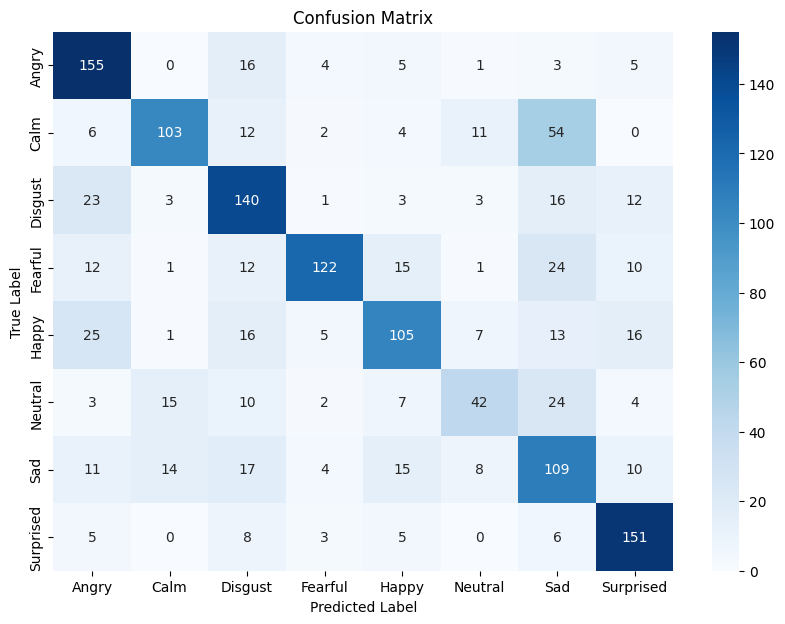

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model_vit.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


**CNN+Vision Transformer+Bidirectional LSTM**

Model: "ViT_CNN_BiLSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_92 (Conv2D)        │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_85    │ (None, 128, 128, 64)   │            256 │ conv2d_92[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_85          │ (None, 64, 64, 64)     │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_144 (Dropout)     │ (None, 64, 64, 64)     │              0 │ max_pooling2d_85[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_93 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ dropout_144[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_86    │ (None, 64, 64, 128)    │            512 │ conv2d_93[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_86          │ (None, 32, 32, 128)    │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_145 (Dropout)     │ (None, 32, 32, 128)    │              0 │ max_pooling2d_86[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ dropout_145[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_87    │ (None, 32, 32, 256)    │          1,024 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_87          │ (None, 16, 16, 256)    │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_146 (Dropout)     │ (None, 16, 16, 256)    │              0 │ max_pooling2d_87[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 1, 1, 64)       │      4,194,368 │ dropout_146[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_10 (Reshape)      │ (None, 1, 64)          │              0 │ conv2d_95[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_27 (Add)              │ (1, 16, 64)            │              0 │ reshape_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2

 Total params: 5,563,208 (21.22 MB)

 Trainable params: 5,562,312 (21.22 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 207ms/step - accuracy: 0.1543 - loss: 4.6206 - val_accuracy: 0.1580 - val_loss: 4.3923
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - accuracy: 0.2150 - loss: 4.2286 - val_accuracy: 0.1267 - val_loss: 4.1615
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 198ms/step - accuracy: 0.2923 - loss: 3.8147 - val_accuracy: 0.1432 - val_loss: 3.8567
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - accuracy: 0.3220 - loss: 3.5200 - val_accuracy: 0.1797 - val_loss: 3.6109
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 0.3465 - loss: 3.2565 - val_accuracy: 0.2405 - val_loss: 3.3931
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 0.3841 - loss: 3.0331 - val_accuracy: 0.2951 - val_loss: 3.1465
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 0.4047 - loss: 2.8172 - val_accuracy: 0.3394 - val_loss: 2.9279
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 196ms/step - accuracy: 0.4524 - loss: 2.5893 - val_accu

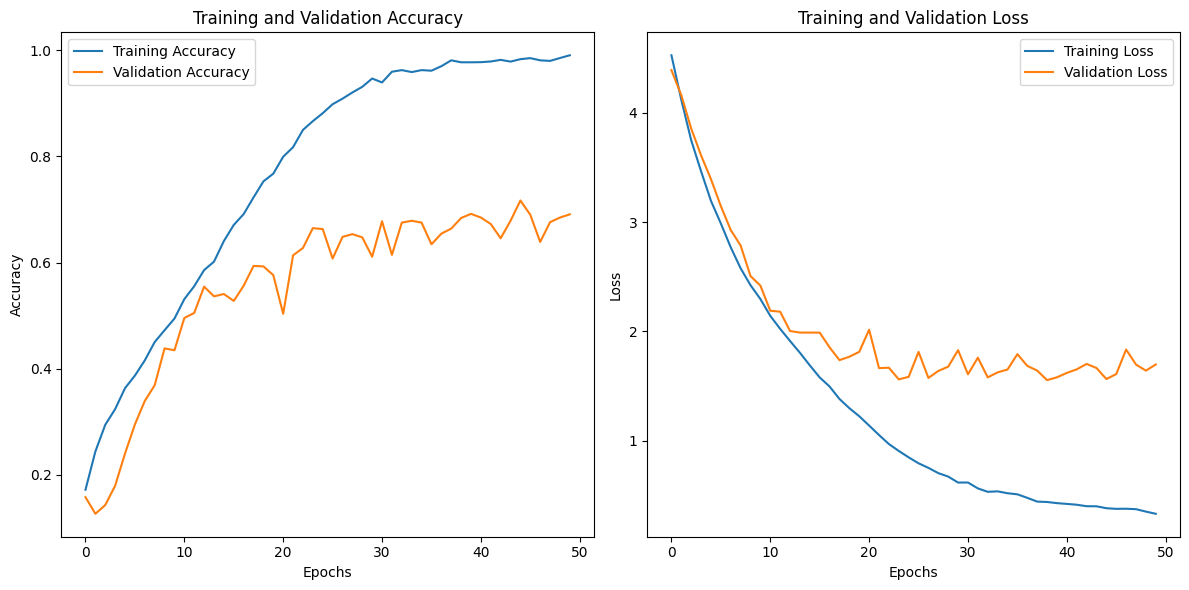

In [ ]:
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf

# Function to create Positional Encodings
def get_positional_encoding(num_patches, embedding_dim):
    position = tf.range(num_patches, dtype=tf.float32)  # Shape (num_patches, 1)
    position = position[:, tf.newaxis]

    div_term = tf.exp(tf.range(0, embedding_dim, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / embedding_dim))  # Correct range

    # Calculate the positional encoding without in-place modification
    sinusoid = tf.sin(position * div_term)
    cosinusoid = tf.cos(position * div_term)

    # Stack the sinusoidal components to form the positional encoding
    positional_encoding = tf.concat([sinusoid, cosinusoid], axis=-1)

    return positional_encoding

# Vision Transformer Model Block
def create_vit_model(input_shape, num_classes, patch_size=16, num_patches=16, embedding_dim=64, num_heads=8, num_layers=4):
    inputs = layers.Input(shape=input_shape, name="input_layer")

    # Step 1: Convolutional Blocks for Feature Extraction
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Step 2: Patch Creation
    patch_size = 16
    patches = layers.Conv2D(embedding_dim, patch_size, strides=patch_size)(x)  # Patching image

    # Reshape patches into a sequence (batch_size, num_patches, embedding_dim)
    patches = layers.Reshape((-1, embedding_dim))(patches)

    # Step 3: Positional Embeddings
    positional_encoding = get_positional_encoding(num_patches, embedding_dim)
    positional_encoding = tf.expand_dims(positional_encoding, axis=0)  # Add batch dimension
    x = layers.Add()([patches, positional_encoding])

    # Step 4: Transformer Blocks (Self-attention mechanism)
    for _ in range(num_layers):
        x1 = layers.LayerNormalization()(x)

        # Multi-Head Self-Attention (Built-in version from Keras)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x1, x1)
        attention_output = layers.Dropout(0.1)(attention_output)
        x = layers.Add()([x, attention_output])  # Skip Connection

        # Feed Forward Network
        x1 = layers.LayerNormalization()(x)
        ffn_output = layers.Dense(embedding_dim * 4, activation='relu')(x1)
        ffn_output = layers.Dense(embedding_dim)(ffn_output)
        ffn_output = layers.Dropout(0.1)(ffn_output)
        x = layers.Add()([x, ffn_output])  # Skip Connection

    # Step 5: Bidirectional LSTM Layer
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)  # Adding Bidirectional LSTM
    x = layers.GlobalAveragePooling1D()(x)  # Global pooling to reduce sequence length to a vector

    # Step 6: Classification Head
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create Model
    model = models.Model(inputs=inputs, outputs=outputs, name="ViT_CNN_BiLSTM_Classifier")
    return model

# Adjust the input shape here for grayscale images (128x128, 1 channel)
input_shape = (128, 128, 1)  # Grayscale (1 channel)
num_classes = 8  # Set the number of output classes

# Create the model
model_vit = create_vit_model(input_shape, num_classes)

# Compile the model
model_vit.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Print model summary
model_vit.summary()

# Train the model (ensure X_train, y_train, X_val, y_val, X_test, and y_test are defined)
history = model_vit.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the model
test_loss, test_acc = model_vit.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


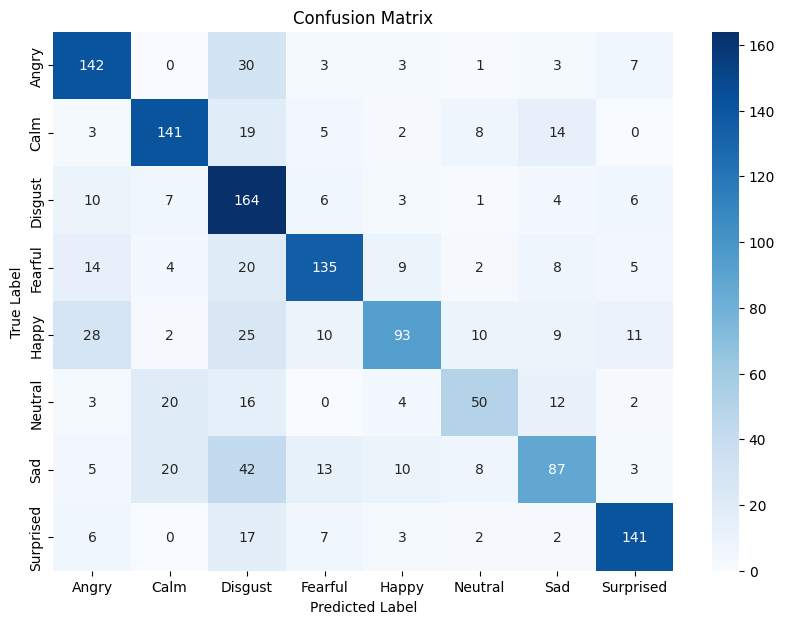

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model_vit.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


**Larger CNN+Vision Transformer+Bidirectional LSTM**

Model: "ViT_CNN_BiLSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 128, 128, 64)   │            256 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 64, 64, 64)     │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_85 (Dropout)      │ (None, 64, 64, 64)     │              0 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ dropout_85[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 64, 64, 128)    │            512 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 32, 32, 128)    │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_86 (Dropout)      │ (None, 32, 32, 128)    │              0 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ dropout_86[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 32, 32, 256)    │          1,024 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 16, 16, 256)    │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_87 (Dropout)      │ (None, 16, 16, 256)    │              0 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 1, 1, 64)       │      4,194,368 │ dropout_87[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_8 (Reshape)       │ (None, 1, 64)          │              0 │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_56 (Add)              │ (1, 1, 64)             │              0 │ reshape_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4

 Total params: 5,563,208 (21.22 MB)

 Trainable params: 5,562,312 (21.22 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (64, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.1674 - loss: 4.5534 - val_accuracy: 0.1345 - val_loss: 4.2548
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - accuracy: 0.2382 - loss: 4.0297 - val_accuracy: 0.0929 - val_loss: 3.8937
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - accuracy: 0.3192 - loss: 3.5137 - val_accuracy: 0.1146 - val_loss: 3.6077
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - accuracy: 0.3370 - loss: 3.1579 - val_accuracy: 0.2066 - val_loss: 3.2570
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - accuracy: 0.3700 - loss: 2.8457 - val_accuracy: 0.2743 - val_loss: 3.0168
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - accuracy: 0.4228 - loss: 2.5898 - val_accuracy: 0.3177 - val_loss: 2.8385
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - accuracy: 0.4489 - loss: 2.3997 - val_accuracy: 0.3594 - val_loss: 2.6244
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 187ms/step - accuracy: 0.4882 - loss: 2.1955 - val_accuracy: 0.415

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


45/45 - 2s - 43ms/step - accuracy: 0.6590 - loss: 1.6728
Test accuracy: 0.6590277552604675


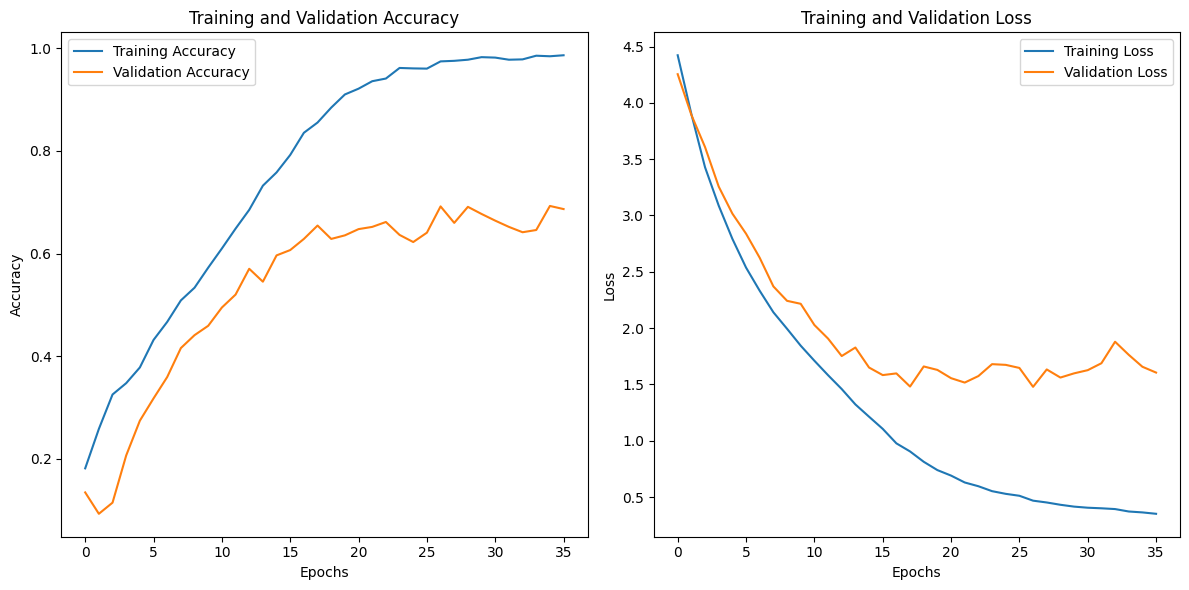

In [14]:
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf

# Function to create Positional Encodings
def get_positional_encoding(num_patches, embedding_dim):
    position = tf.range(num_patches, dtype=tf.float32)  # Shape (num_patches, 1)
    position = position[:, tf.newaxis]

    div_term = tf.exp(tf.range(0, embedding_dim, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / embedding_dim))  # Correct range

    # Calculate the positional encoding without in-place modification
    sinusoid = tf.sin(position * div_term)
    cosinusoid = tf.cos(position * div_term)

    # Stack the sinusoidal components to form the positional encoding
    positional_encoding = tf.concat([sinusoid, cosinusoid], axis=-1)

    return positional_encoding

# Vision Transformer Model Block
def create_vit_model(input_shape, num_classes, patch_size=16, num_patches=16, embedding_dim=64, num_heads=8, num_layers=4):
    inputs = layers.Input(shape=input_shape, name="input_layer")

    # Step 1: Convolutional Blocks for Feature Extraction
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Step 2: Patch Creation
    patch_size = 16
    patches = layers.Conv2D(embedding_dim, patch_size, strides=patch_size)(x)  # Patching image

    # Reshape patches into a sequence (batch_size, num_patches, embedding_dim)
    patches = layers.Reshape((-1, embedding_dim))(patches)

    # Step 3: Positional Embeddings
    num_patches = patches.shape[1]  # Get the actual number of patches
    positional_encoding = get_positional_encoding(num_patches, embedding_dim)
    positional_encoding = tf.expand_dims(positional_encoding, axis=0)  # Add batch dimension
    x = layers.Add()([patches, positional_encoding])

    # Step 4: Transformer Blocks (Self-attention mechanism)
    for _ in range(num_layers):
        x1 = layers.LayerNormalization()(x)

        # Multi-Head Self-Attention (Built-in version from Keras)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x1, x1)
        attention_output = layers.Dropout(0.1)(attention_output)
        x = layers.Add()([x, attention_output])  # Skip Connection

        # Feed Forward Network
        x1 = layers.LayerNormalization()(x)
        ffn_output = layers.Dense(embedding_dim * 4, activation='relu')(x1)
        ffn_output = layers.Dense(embedding_dim)(ffn_output)
        ffn_output = layers.Dropout(0.1)(ffn_output)
        x = layers.Add()([x, ffn_output])  # Skip Connection

    # Step 5: Bidirectional LSTM Layer
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)  # Adding Bidirectional LSTM
    x = layers.GlobalAveragePooling1D()(x)  # Global pooling to reduce sequence length to a vector

    # Step 6: Classification Head
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create Model
    model = models.Model(inputs=inputs, outputs=outputs, name="ViT_CNN_BiLSTM_Classifier")
    return model

# Adjust the input shape here for grayscale images (128x128, 1 channel)
input_shape = (128, 128, 1)  # Grayscale (1 channel)
num_classes = 8  # Set the number of output classes

# Create the model
model_vit = create_vit_model(input_shape, num_classes)

# Compile the model
model_vit.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Print model summary
model_vit.summary()

# Create the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss (you can change it to 'val_accuracy' if preferred)
    patience=9,  # Stop training after 5 epochs with no improvement
    verbose=1,  # Display messages when stopping
    restore_best_weights=True  # Restore the best weights when stopping
)

# Train the model with early stopping
history = model_vit.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[early_stopping]  # Add the early stopping callback
)

# Evaluate the model
test_loss, test_acc = model_vit.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


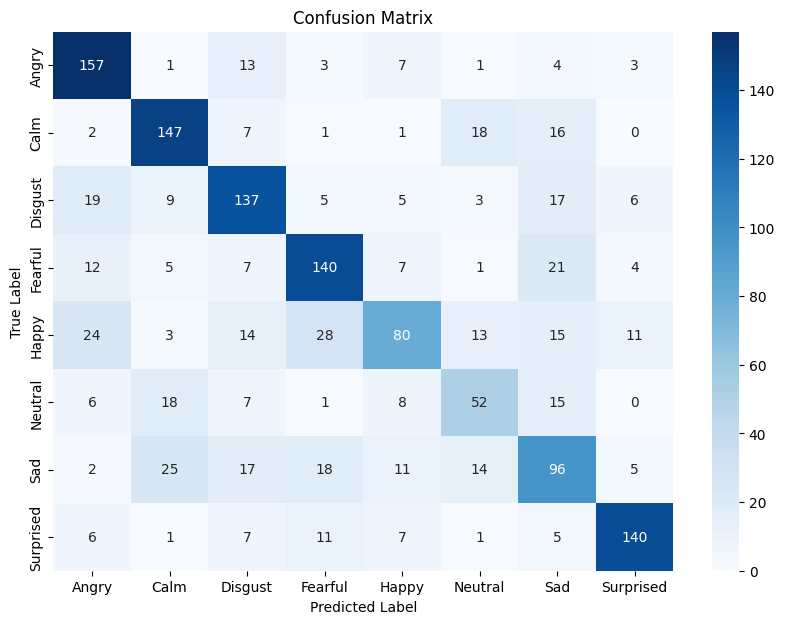

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model_vit.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


**EfficientNet+Transformer**

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout,
    BatchNormalization, Input, MultiHeadAttention, LayerNormalization, Reshape
)
from tensorflow.keras.applications import EfficientNetB0

class PositionalEncodingLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(PositionalEncodingLayer, self).__init__(**kwargs)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        depth = tf.shape(x)[-1]
        position = tf.range(0, seq_len, dtype=tf.float32)
        position = tf.expand_dims(position, axis=-1) / tf.pow(10000.0, tf.range(0, depth, 2, dtype=tf.float32) / tf.cast(depth, tf.float32))
        position_encoding = tf.concat([tf.sin(position), tf.cos(position)], axis=-1)
        position_encoding = tf.expand_dims(position_encoding, axis=0)
        return x + position_encoding

def squeeze_and_excite_block(inputs, ratio=16):
    filters = inputs.shape[-1]
    se = layers.GlobalAveragePooling2D()(inputs)
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    return layers.Multiply()([inputs, se])

def create_improved_cnn_with_transformer(input_shape, num_classes):
    inputs = Input(shape=input_shape, name="input_layer")

    # Pre-trained Feature Extractor
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False  # Freeze base model weights
    x = base_model(inputs, training=False)

    # Add Squeeze-and-Excite Block
    x = squeeze_and_excite_block(x)

    # Additional Convolutional Block
    x = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Reshape output for Transformer layer
    x = Reshape((-1, x.shape[-1]))(x)

    # Add Positional Encoding
    x = PositionalEncodingLayer()(x)

    # Transformer Layers
    for _ in range(2):  # Add 2 stacked Transformer layers
        transformer = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
        transformer = LayerNormalization()(transformer)
        x = layers.Add()([x, transformer])  # Residual connection
        x = LayerNormalization()(x)

    # Global Average Pooling along time dimension
    x = layers.GlobalAveragePooling1D()(x)

    # Fully Connected Layers
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create Model
    model = models.Model(inputs=inputs, outputs=outputs, name="Improved_CNN_with_Transformer")
    return model

# Define input shape and number of classes
input_shape = (128, 128, 3)  # RGB images
num_classes = 8

# Create the model
model = create_improved_cnn_with_transformer(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=7, restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (64, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 45s 178ms/step - accuracy: 0.2144 - loss: 19.9895 - val_accuracy: 0.1380 - val_loss: 17.3453
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.3483 - loss: 16.2911 - val_accuracy: 0.2839 - val_loss: 14.1818
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.4148 - loss: 13.2753 - val_accuracy: 0.3490 - val_loss: 11.7625
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.4391 - loss: 11.0319 - val_accuracy: 0.4306 - val_loss: 9.8971
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.4480 - loss: 9.3587 - val_accuracy: 0.4115 - val_loss: 8.4789
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.4978 - loss: 8.0374 - val_accuracy: 0.4401 - val_loss: 7.3916
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.5148 - loss: 7.0559 - val_accuracy: 0.4783 - val_loss: 6.5552
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.5161 - loss: 6.2799 - val_accuracy: 0.5234 - val

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


45/45 - 11s - 239ms/step - accuracy: 0.5979 - loss: 1.7115
Test accuracy: 0.5979166626930237


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step


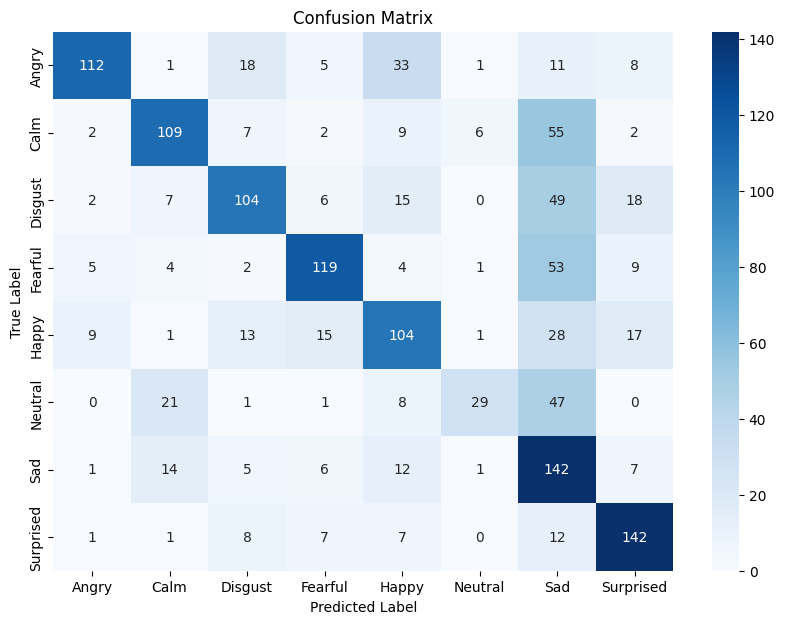

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


**Advanced CNN+LSTM**

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 229ms/step - accuracy: 0.1855 - loss: 16.0000 - val_accuracy: 0.0538 - val_loss: 10.6829 - learning_rate: 1.0000e-04
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 220ms/step - accuracy: 0.2299 - loss: 9.5028 - val_accuracy: 0.1493 - val_loss: 7.2881 - learning_rate: 1.0000e-04
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 218ms/step - accuracy: 0.2949 - loss: 6.5675 - val_accuracy: 0.1337 - val_loss: 5.7383 - learning_rate: 1.0000e-04
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 217ms/step - accuracy: 0.3447 - loss: 5.1309 - val_accuracy: 0.1345 - val_loss: 5.0298 - learning_rate: 1.0000e-04
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 217ms/step - accuracy: 0.4126 - loss: 4.2870 - val_accuracy: 0.1884 - val_loss: 4.6295 - learning_rate: 1.0000e-04
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 218ms/step - accuracy: 0.4920 - loss: 3.7124 - val_accuracy: 0.2101 - val_loss: 4.6549 - learning_rate: 1.0000e-04
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 219ms/s

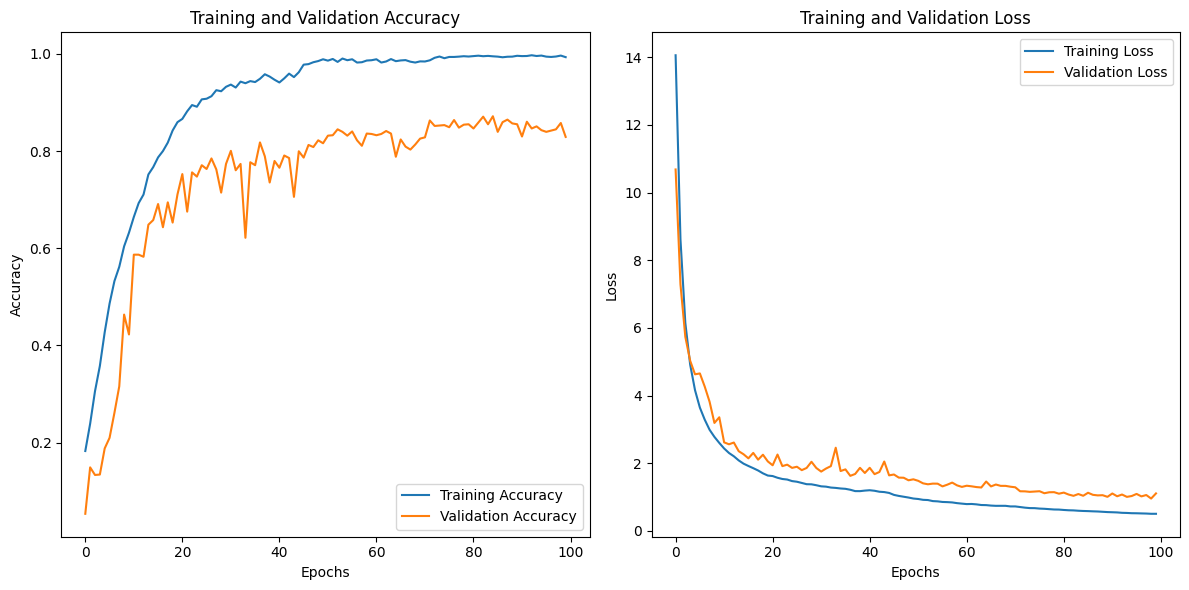

In [20]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, Flatten, LSTM, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

def create_advanced_cnn_with_lstm(input_shape, num_classes):
    inputs = Input(shape=input_shape, name="input_layer")

    # Convolutional Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Convolutional Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Convolutional Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Convolutional Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Additional Convolutional Block
    x = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Reshape for LSTM layers
    x = Flatten()(x)
    x = Reshape((-1, 1024))(x)

    # LSTM Layers
    x = LSTM(512, return_sequences=True)(x)
    x = LSTM(256, return_sequences=False)(x)

    # Fully Connected Layer
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create Model
    model = models.Model(inputs=inputs, outputs=outputs, name="Advanced_CNN_with_LSTM")
    return model

# Model configuration
input_shape = (128, 128, 1)  # Grayscale input
num_classes = 8
model = create_advanced_cnn_with_lstm(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    verbose=1
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# Plot training and validation metrics
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


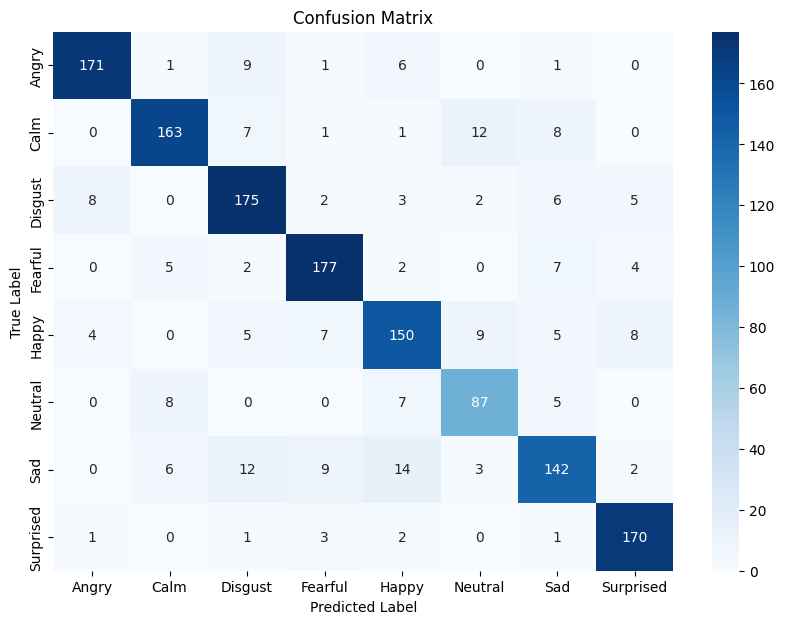

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


**Advanced CNN+Bidirectional LSTM**

Model: "Bidirectional_CNN_with_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_125 (Dropout)                │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_126 (Dropout)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_127 (Dropout)                │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_128 (Dropout)                │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 8, 8, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 8, 8, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │              

 Total params: 38,542,088 (147.03 MB)

 Trainable params: 38,534,024 (147.00 MB)

 Non-trainable params: 8,064 (31.50 KB)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 289ms/step - accuracy: 0.1710 - loss: 29.3137 - val_accuracy: 0.1337 - val_loss: 19.1700 - learning_rate: 1.0000e-04
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 276ms/step - accuracy: 0.2695 - loss: 16.9636 - val_accuracy: 0.1484 - val_loss: 12.7013 - learning_rate: 1.0000e-04
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 273ms/step - accuracy: 0.3263 - loss: 11.3529 - val_accuracy: 0.1441 - val_loss: 9.5670 - learning_rate: 1.0000e-04
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 274ms/step - accuracy: 0.3856 - loss: 8.4597 - val_accuracy: 0.2066 - val_loss: 7.8411 - learning_rate: 1.0000e-04
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - accuracy: 0.4180 - loss: 6.8108 - val_accuracy: 0.1918 - val_loss: 6.9294 - learning_rate: 1.0000e-04
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - accuracy: 0.4638 - loss: 5.7606 - val_accuracy: 0.2405 - val_loss: 6.2628 - learning_rate: 1.0000e-04
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 274m

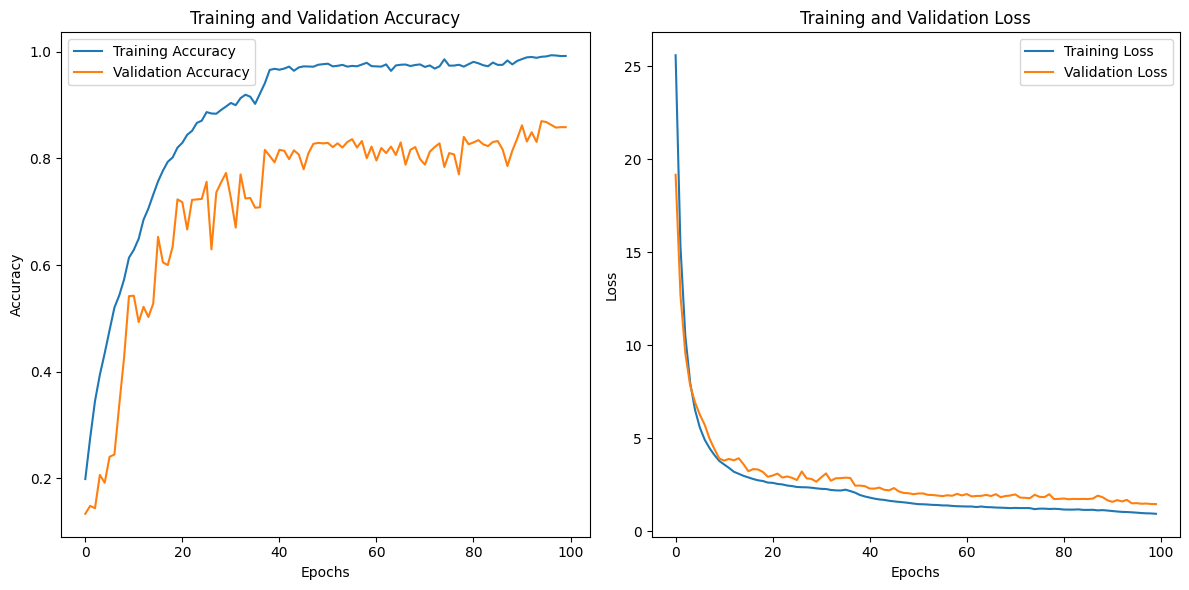

In [23]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, Flatten, LSTM, Reshape, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

def create_bidirectional_cnn_lstm(input_shape, num_classes):
    inputs = Input(shape=input_shape, name="input_layer")

    # Convolutional Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Convolutional Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Convolutional Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Convolutional Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Additional Convolutional Block 5
    x = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Additional Convolutional Block 6
    x = Conv2D(2048, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Reshape for Bidirectional LSTM
    x = Flatten()(x)
    x = Reshape((-1, 2048))(x)

    # Bidirectional LSTM Layers
    x = Bidirectional(LSTM(512, return_sequences=True))(x)
    x = Bidirectional(LSTM(256, return_sequences=False))(x)

    # Fully Connected Layer
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create Model
    model = models.Model(inputs=inputs, outputs=outputs, name="Bidirectional_CNN_with_LSTM")
    return model

# Model configuration
input_shape = (128, 128, 1)  # Grayscale input
num_classes = 8
model = create_bidirectional_cnn_lstm(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    verbose=1
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# Plot training and validation metrics
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


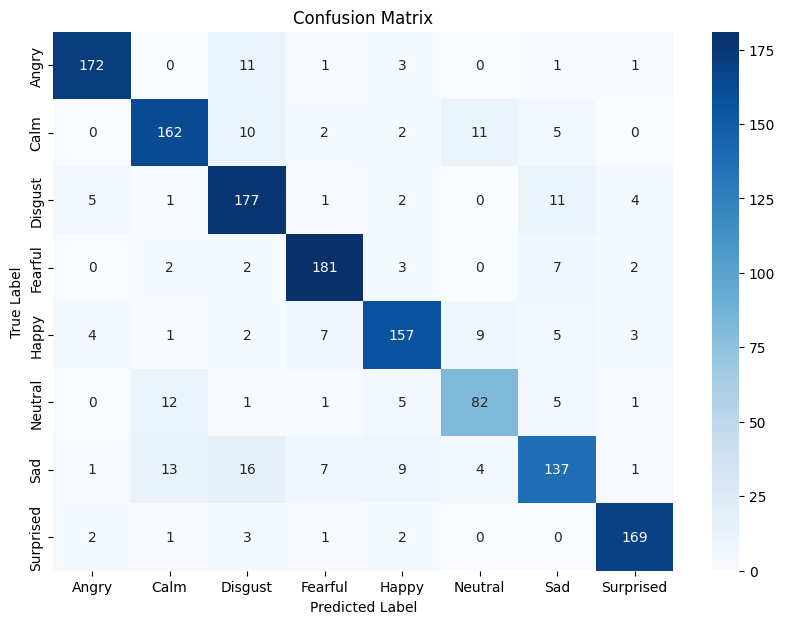

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


**Advanced CNN+Bidirectional LSTM with batch size 32**

Model: "Bidirectional_CNN_with_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_132 (Dropout)                │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_133 (Dropout)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_134 (Dropout)                │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_135 (Dropout)                │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 8, 8, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 8, 8, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │              

 Total params: 38,542,088 (147.03 MB)

 Trainable params: 38,534,024 (147.00 MB)

 Non-trainable params: 8,064 (31.50 KB)

Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 34s 177ms/step - accuracy: 0.1847 - loss: 27.1238 - val_accuracy: 0.1241 - val_loss: 13.9892 - learning_rate: 1.0000e-04
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 24s 169ms/step - accuracy: 0.2797 - loss: 11.8237 - val_accuracy: 0.1319 - val_loss: 8.1184 - learning_rate: 1.0000e-04
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 24s 169ms/step - accuracy: 0.3459 - loss: 7.0715 - val_accuracy: 0.2378 - val_loss: 6.0023 - learning_rate: 1.0000e-04
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 24s 169ms/step - accuracy: 0.4161 - loss: 5.2341 - val_accuracy: 0.3498 - val_loss: 4.8032 - learning_rate: 1.0000e-04
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 24s 170ms/step - accuracy: 0.4665 - loss: 4.2693 - val_accuracy: 0.4089 - val_loss: 4.0690 - learning_rate: 1.0000e-04
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 0.5224 - loss: 3.7566 - val_accuracy: 0.2986 - val_loss: 4.1947 - learning_rate: 1.0000e-04
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━

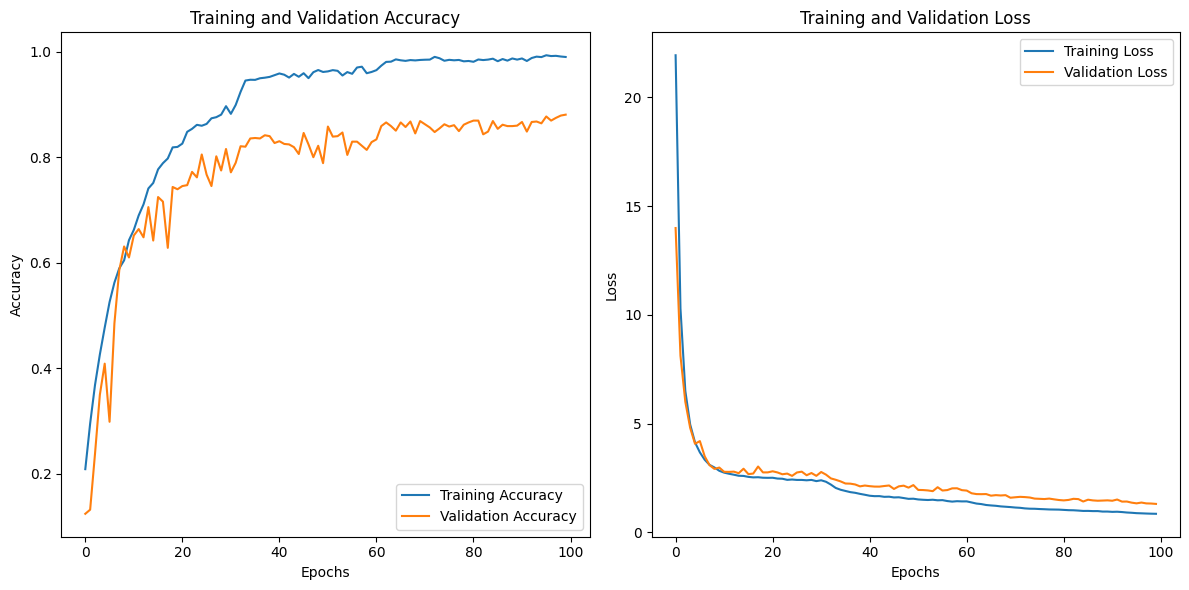

In [25]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, Flatten, LSTM, Reshape, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

def create_bidirectional_cnn_lstm(input_shape, num_classes):
    inputs = Input(shape=input_shape, name="input_layer")

    # Convolutional Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Convolutional Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Convolutional Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Convolutional Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Additional Convolutional Block 5
    x = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Additional Convolutional Block 6
    x = Conv2D(2048, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Reshape for Bidirectional LSTM
    x = Flatten()(x)
    x = Reshape((-1, 2048))(x)

    # Bidirectional LSTM Layers
    x = Bidirectional(LSTM(512, return_sequences=True))(x)
    x = Bidirectional(LSTM(256, return_sequences=False))(x)

    # Fully Connected Layer
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create Model
    model = models.Model(inputs=inputs, outputs=outputs, name="Bidirectional_CNN_with_LSTM")
    return model

# Model configuration
input_shape = (128, 128, 1)  # Grayscale input
num_classes = 8
model = create_bidirectional_cnn_lstm(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    verbose=1
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# Plot training and validation metrics
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


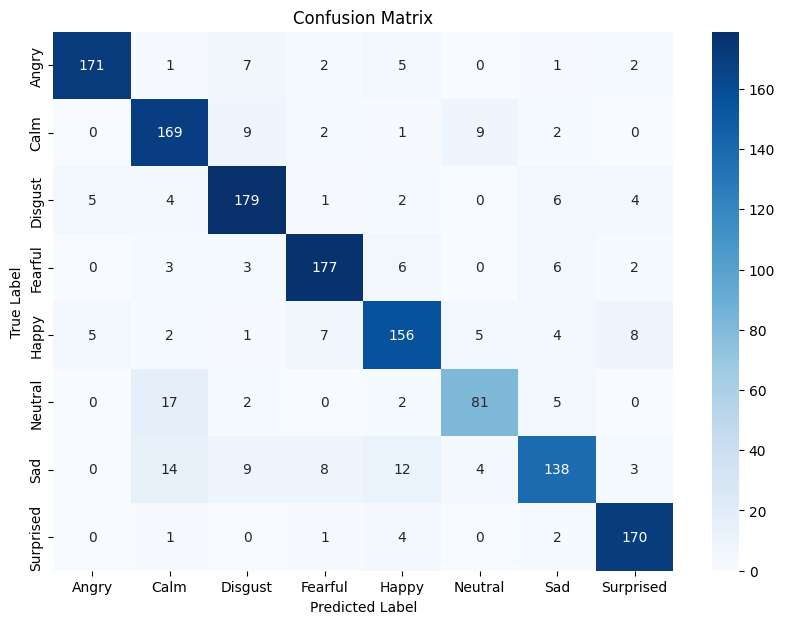

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [39]:
# Save the model to a file
model.save('/content/drive/MyDrive/SER_Models/SER3.h5')  # Specify the path where you want to save the model

**Testing model on EmoDB dataset**

In [61]:
from tensorflow.keras.models import load_model
# Load the model from the saved file
model = load_model('/content/drive/MyDrive/SER_Models/SER3.h5')  # Use the correct path to your saved model

# Use the same emotion mapping
emotion_mapping = {
    'Neutral': 'Neutral',
    'Calm': 'Calm',
    'Happy': 'Happy',
    'Sad': 'Sad',
    'Angry': 'Angry',
    'Fearful': 'Fearful',
    'Disgust': 'Disgust',
    'Surprised': 'Surprised'
}

# Define the prediction function as before
def predict_emotion(audio_path, model, label_encoder, emotion_mapping, sr=22050, n_mels=128, fmax=8000, max_len=128):
    # Load and process audio (same as before)
    y, sr = librosa.load(audio_path, sr=sr)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Padding or truncating to ensure consistent length
    if mel_spectrogram_db.shape[1] > max_len:
        mel_spectrogram_db = mel_spectrogram_db[:, :max_len]
    elif mel_spectrogram_db.shape[1] < max_len:
        pad_width = max_len - mel_spectrogram_db.shape[1]
        mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, pad_width)), mode='constant')

    # Expand dimensions to match input shape
    mel_spectrogram_db = np.expand_dims(mel_spectrogram_db, axis=-1)  # Add channel dimension
    mel_spectrogram_db = np.expand_dims(mel_spectrogram_db, axis=0)   # Add batch dimension

    # Make prediction
    predictions = model.predict(mel_spectrogram_db)
    predicted_class_index = np.argmax(predictions, axis=1)  # Get index of the highest probability

    # Decode predicted class to emotion name
    predicted_class = label_encoder.inverse_transform(predicted_class_index)

    # Map the predicted class to emotion based on emotion_mapping
    predicted_emotion = emotion_mapping.get(predicted_class[0], "Unknown")

    # Convert probabilities to percentages
    prediction_percentages = predictions[0] * 100
    prediction_percentages = [f"{prob:.2f}%" for prob in prediction_percentages]

    return predicted_emotion, prediction_percentages

# Test the prediction with the loaded model
audio_path = "/content/drive/MyDrive/EmoDB/Happy/08a05Fe.wav"  # Replace with the correct file path
predicted_emotion, prediction_percentages = predict_emotion(audio_path, model, label_encoder, emotion_mapping)

# Print the result
print(f"Predicted Emotion: {predicted_emotion}")
print("Class Probabilities (in percentages):", prediction_percentages)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
Predicted Emotion: Fearful
Class Probabilities (in percentages): ['3.92%', '0.19%', '0.04%', '71.26%', '0.98%', '0.23%', '0.13%', '23.23%']


In [59]:
from tensorflow.keras.models import load_model
import os
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load the model from the saved file
model = load_model('/content/drive/MyDrive/SER_Models/SER3.h5')  # Use the correct path to your saved model

# Use the same emotion mapping
emotion_mapping = {
    'Neutral': 'Neutral',
    'Calm': 'Calm',
    'Happy': 'Happy',
    'Sad': 'Sad',
    'Angry': 'Angry',
    'Fearful': 'Fearful',
    'Disgust': 'Disgust',
    'Surprised': 'Surprised'
}

# Initialize the label encoder (you should have this from your training phase)
label_encoder = LabelEncoder()
label_encoder.fit(list(emotion_mapping.values()))  # You should fit it with your actual emotion labels

# Define the prediction function
def predict_emotion(audio_path, model, label_encoder, emotion_mapping, sr=22050, n_mels=128, fmax=8000, max_len=128):
    # Load and process audio (same as before)
    y, sr = librosa.load(audio_path, sr=sr)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Padding or truncating to ensure consistent length
    if mel_spectrogram_db.shape[1] > max_len:
        mel_spectrogram_db = mel_spectrogram_db[:, :max_len]
    elif mel_spectrogram_db.shape[1] < max_len:
        pad_width = max_len - mel_spectrogram_db.shape[1]
        mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, pad_width)), mode='constant')

    # Expand dimensions to match input shape
    mel_spectrogram_db = np.expand_dims(mel_spectrogram_db, axis=-1)  # Add channel dimension
    mel_spectrogram_db = np.expand_dims(mel_spectrogram_db, axis=0)   # Add batch dimension

    # Make prediction
    predictions = model.predict(mel_spectrogram_db)
    predicted_class_index = np.argmax(predictions, axis=1)  # Get index of the highest probability

    # Decode predicted class to emotion name
    predicted_class = label_encoder.inverse_transform(predicted_class_index)

    # Map the predicted class to emotion based on emotion_mapping
    predicted_emotion = emotion_mapping.get(predicted_class[0], "Unknown")

    # Convert probabilities to percentages
    prediction_percentages = predictions[0] * 100
    prediction_percentages = [f"{prob:.2f}%" for prob in prediction_percentages]

    return predicted_emotion, prediction_percentages

# Define paths to class folders in the EmoDB dataset
class_paths = {
    'Angry': '/content/drive/MyDrive/EmoDB/Angry',
    'Disgust': '/content/drive/MyDrive/EmoDB/Disgust',
    'Happy': '/content/drive/MyDrive/EmoDB/Happy',
    'Sad': '/content/drive/MyDrive/EmoDB/Sad',
    'Neutral': '/content/drive/MyDrive/EmoDB/Neutral',
    'Fearful': '/content/drive/MyDrive/EmoDB/Fear'
}

# Variables to calculate accuracy for each emotion
emotion_accuracies = {emotion: {'total_predictions': 0, 'correct_predictions': 0} for emotion in class_paths}

# Combine all class folders into one list of audio files
audio_files = []
for emotion, folder_path in class_paths.items():
    audio_files += [(emotion, os.path.join(folder_path, f)) for f in os.listdir(folder_path) if f.endswith('.wav')]

# Loop through audio files and get predictions
for emotion, audio_path in audio_files:
    # Get the predicted emotion and probabilities
    predicted_emotion, _ = predict_emotion(audio_path, model, label_encoder, emotion_mapping)

    # Track predictions for each emotion
    emotion_accuracies[emotion]['total_predictions'] += 1
    if predicted_emotion == emotion:
        emotion_accuracies[emotion]['correct_predictions'] += 1

# Print accuracy results for each emotion
for emotion, accuracy_data in emotion_accuracies.items():
    if accuracy_data['total_predictions'] > 0:
        accuracy = (accuracy_data['correct_predictions'] / accuracy_data['total_predictions']) * 100
        print(f"Total Predictions for {emotion}: {accuracy_data['total_predictions']}")
        print(f"{emotion} Predictions: {accuracy_data['correct_predictions']}")
        print(f"{emotion} Accuracy: {accuracy:.2f}%")
    else:
        print(f"No predictions were made for {emotion}.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━